<a href="https://colab.research.google.com/github/shimaaosaman/GAN/blob/main/assignment1_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install datasets

import re
import math
from collections import defaultdict
from datasets import load_dataset
dataset = load_dataset("imdb", split="unsupervised")

# Split into train (80%) and test (20%) using Dataset's built-in method to avoid type issues
split_datasets = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

train_texts = train_dataset['text']
test_texts = test_dataset['text']

## Data Preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()
    return tokens
# Also build unigram for reference

unigram_counts = defaultdict(int)
bigram_counts = defaultdict(int)
vocab = set()

for review in train_texts:
    tokens = preprocess(review)
    tokens = ['<s>'] + tokens + ['</s>']  # Add start and end tokens
    for t in tokens:
        unigram_counts[t] += 1
        vocab.add(t)
    for i in range(1, len(tokens)):
        bi = (tokens[i-1], tokens[i])
        bigram_counts[bi] += 1

V = len(vocab)  # Vocabulary size

## Evaluation: Perplexity on Test Set
def compute_perplexity(test_texts):
    total_log_prob = 0
    total_N = 0
    for review in test_texts:
        tokens = preprocess(review)
        tokens = ['<s>'] + tokens + ['</s>']
        for i in range(1, len(tokens)):
            prev = tokens[i-1]
            w = tokens[i]
            count_bi = bigram_counts.get((prev, w), 0)
            count_uni = unigram_counts.get(prev, 0)
            prob = (count_bi + 1) / (count_uni + V)  # Laplace smoothing
            total_log_prob += math.log(prob + 1e-10)  # Avoid log(0)
        total_N += len(tokens) - 1
    if total_N == 0:
        return float('inf')
    avg_log_prob = total_log_prob / total_N
    perplexity = math.exp(-avg_log_prob)
    return perplexity

pp_bigram = compute_perplexity(test_texts)
print(f"Bigram Perplexity on Test Set: {pp_bigram}")

# Optional: Unigram Perplexity for Comparison
total_unigrams = sum(unigram_counts.values())

def unigram_perplexity(test_texts):
    total_log_prob = 0
    total_N = 0
    for review in test_texts:
        tokens = preprocess(review)
        tokens = ['<s>'] + tokens + ['</s>']
        for t in tokens[1:]:
            prob = (unigram_counts.get(t, 0) + 1) / (total_unigrams + V)
            total_log_prob += math.log(prob + 1e-10)
        total_N += len(tokens) - 1
    avg_log_prob = total_log_prob / total_N
    perplexity = math.exp(-avg_log_prob)
    return perplexity

pp_unigram = unigram_perplexity(test_texts)
print(f"Unigram Perplexity on Test Set: {pp_unigram}")


Bigram Perplexity on Test Set: 4030.4185468466612
Unigram Perplexity on Test Set: 1301.577986006616


Downloading...
From: https://drive.google.com/uc?id=1SxlV-0sw64qr0ykyjTsu-C2GDiBB_NdU
To: /content/spam.txt
100%|██████████| 504k/504k [00:00<00:00, 70.9MB/s]


Naive Bayes Confusion Matrix:
 [[1115    0]
 [   0    0]]
Naive Bayes Metrics: {'precision_ham': np.float64(1.0), 'precision_spam': 0, 'macro_precision': np.float64(0.5), 'recall_ham': np.float64(1.0), 'recall_spam': 0, 'macro_recall': np.float64(0.5), 'f1_ham': np.float64(1.0), 'f1_spam': 0, 'macro_f1': np.float64(0.5)}
Logistic Regression Confusion Matrix:
 [[1115    0]
 [   0    0]]
Logistic Regression Metrics: {'precision_ham': np.float64(1.0), 'precision_spam': 0, 'macro_precision': np.float64(0.5), 'recall_ham': np.float64(1.0), 'recall_spam': 0, 'macro_recall': np.float64(0.5), 'f1_ham': np.float64(1.0), 'f1_spam': 0, 'macro_f1': np.float64(0.5)}

Model Comparison:
            Metric  Naive Bayes  Logistic Regression
0  Macro Precision          0.5                  0.5
1     Macro Recall          0.5                  0.5
2         Macro F1          0.5                  0.5


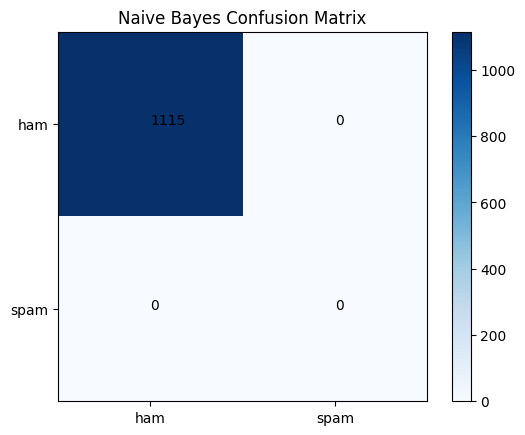

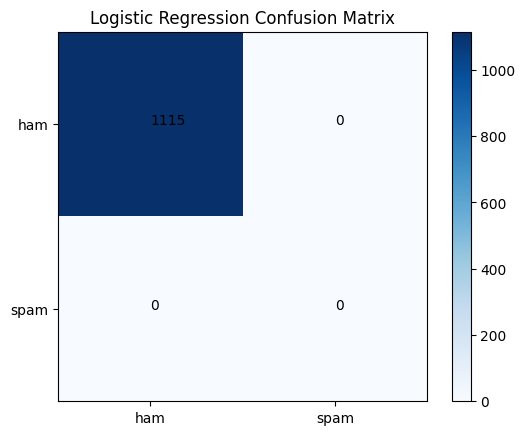

In [ ]:
# Part 2: Text Classification (Ham or Spam)
!pip install gdown

import re
import math
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt


import gdown
gdown.download(id='1SxlV-0sw64qr0ykyjTsu-C2GDiBB_NdU', output='spam.txt', quiet=False)

df = pd.read_csv('spam.txt', sep='\t', names=['label', 'message'], encoding='latin-1')

df['message'] = df['message'].astype(str)
labels = df['label'].values
texts = df['message'].values

# Splits: Train 60%, Validation 20%, Test 20%
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.4, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Preprocessing
def preprocess_class(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    return tokens

## Build Vocabulary
all_words = set()
for text in train_texts:
    all_words.update(preprocess_class(text))
vocab_class = list(all_words)
V_class = len(vocab_class)

## Priors
num_spam = np.sum(train_labels == 'spam')
num_ham = len(train_labels) - num_spam
prior_spam = num_spam / len(train_labels)
prior_ham = num_ham / len(train_labels)

## Likelihoods
spam_word_counts = defaultdict(int)
ham_word_counts = defaultdict(int)
total_spam_words = 0
total_ham_words = 0

for text, label in zip(train_texts, train_labels):
    tokens = preprocess_class(text)
    for t in tokens:
        if label == 'spam':
            spam_word_counts[t] += 1
            total_spam_words += 1
        else:
            ham_word_counts[t] += 1
            total_ham_words += 1

## Prediction
def predict_nb(text):
    tokens = preprocess_class(text)
    log_p_spam = math.log(prior_spam) if prior_spam > 0 else -math.inf
    log_p_ham = math.log(prior_ham) if prior_ham > 0 else -math.inf
    for t in tokens:
        p_w_spam = (spam_word_counts.get(t, 0) + 1) / (total_spam_words + V_class)
        p_w_ham = (ham_word_counts.get(t, 0) + 1) / (total_ham_words + V_class)
        log_p_spam += math.log(p_w_spam)
        log_p_ham += math.log(p_w_ham)
    return 'spam' if log_p_spam > log_p_ham else 'ham'

nb_preds = [predict_nb(text) for text in test_texts]

#  Logistic Regression

bigram_set = set()
for text in train_texts:
    tokens = preprocess_class(text)
    for i in range(1, len(tokens)):
        bi = (tokens[i-1], tokens[i])
        bigram_set.add(bi)
bigram_vocab = list(bigram_set)
bigram_index = {bi: idx for idx, bi in enumerate(bigram_vocab)}
D = len(bigram_vocab)

def get_bigram_vector(text):
    tokens = preprocess_class(text)
    vec = np.zeros(D, dtype=np.float32)
    for i in range(1, len(tokens)):
        bi = (tokens[i-1], tokens[i])
        if bi in bigram_index:
            vec[bigram_index[bi]] = 1
    return vec


X_train = np.array([get_bigram_vector(text) for text in train_texts], dtype=np.float32)
y_train = np.array([1 if l == 'spam' else 0 for l in train_labels], dtype=np.float32)

X_val = np.array([get_bigram_vector(text) for text in val_texts], dtype=np.float32)
y_val = np.array([1 if l == 'spam' else 0 for l in val_labels], dtype=np.float32)

X_test = np.array([get_bigram_vector(text) for text in test_texts], dtype=np.float32)
y_test = np.array([1 if l == 'spam' else 0 for l in test_labels], dtype=np.float32)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

w = np.zeros(D, dtype=np.float32)
b = np.float32(0.0)
lr = 0.01
epochs = 20
batch_size = 32

for epoch in range(epochs):
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    for start in range(0, len(X_train), batch_size):
        end = min(start + batch_size, len(X_train))
        batch_idx = indices[start:end]
        X_batch = X_train[batch_idx]
        y_batch = y_train[batch_idx]
        z = np.dot(X_batch, w) + b
        p = sigmoid(z)
        grad_w = np.dot(X_batch.T, (p - y_batch)) / len(batch_idx)
        grad_b = np.mean(p - y_batch)
        w -= lr * grad_w
        b -= lr * grad_b

    del X_batch, y_batch, z, p


def predict_lr(X):
    z = np.dot(X, w) + b
    p = sigmoid(z)
    return ['spam' if pi > 0.5 else 'ham' for pi in p]

lr_preds = predict_lr(X_test)



##Generate Confusion Matrix
def generate_confusion_matrix(y_true, y_pred):
    y_true_num = [1 if yt == 'spam' else 0 for yt in y_true]
    y_pred_num = [1 if yp == 'spam' else 0 for yp in y_pred]
    tp = fp = tn = fn = 0
    for yt, yp in zip(y_true_num, y_pred_num):
        if yt == 1 and yp == 1: tp += 1
        elif yt == 0 and yp == 1: fp += 1
        elif yt == 0 and yp == 0: tn += 1
        elif yt == 1 and yp == 0: fn += 1
    return np.array([[tn, fp], [fn, tp]])

## Compute Metrics
def compute_metrics(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    precision_ham = tn / (tn + fn) if (tn + fn) > 0 else 0
    precision_spam = tp / (tp + fp) if (tp + fp) > 0 else 0
    macro_precision = (precision_ham + precision_spam) / 2

    recall_ham = tn / (tn + fp) if (tn + fp) > 0 else 0
    recall_spam = tp / (tp + fn) if (tp + fn) > 0 else 0
    macro_recall = (recall_ham + recall_spam) / 2

    f1_ham = 2 * precision_ham * recall_ham / (precision_ham + recall_ham) if (precision_ham + recall_ham) > 0 else 0
    f1_spam = 2 * precision_spam * recall_spam / (precision_spam + recall_spam) if (precision_spam + recall_spam) > 0 else 0
    macro_f1 = (f1_ham + f1_spam) / 2

    return {
        'precision_ham': precision_ham, 'precision_spam': precision_spam, 'macro_precision': macro_precision,
        'recall_ham': recall_ham, 'recall_spam': recall_spam, 'macro_recall': macro_recall,
        'f1_ham': f1_ham, 'f1_spam': f1_spam, 'macro_f1': macro_f1
    }

# Results for Naive Bayes
cm_nb = generate_confusion_matrix(test_labels, nb_preds)
metrics_nb = compute_metrics(cm_nb)
print("Naive Bayes Confusion Matrix:\n", cm_nb)
print("Naive Bayes Metrics:", metrics_nb)

# Results for Logistic Regression
cm_lr = generate_confusion_matrix(test_labels, lr_preds)
metrics_lr = compute_metrics(cm_lr)
print("Logistic Regression Confusion Matrix:\n", cm_lr)
print("Logistic Regression Metrics:", metrics_lr)

# Comparison Table
print("\nModel Comparison:")
data = {
    'Metric': ['Macro Precision', 'Macro Recall', 'Macro F1'],
    'Naive Bayes': [metrics_nb['macro_precision'], metrics_nb['macro_recall'], metrics_nb['macro_f1']],
    'Logistic Regression': [metrics_lr['macro_precision'], metrics_lr['macro_recall'], metrics_lr['macro_f1']]
}
comparison_df = pd.DataFrame(data)
print(comparison_df)

# Confusion Matrix Plots
def plot_cm(cm, title):
    plt.imshow(cm, cmap='Blues')
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1], ['ham', 'spam'])
    plt.yticks([0,1], ['ham', 'spam'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j])
    plt.show()

plot_cm(cm_nb, "Naive Bayes Confusion Matrix")
plot_cm(cm_lr, "Logistic Regression Confusion Matrix")
